# Analysis of Definition Evaluations

This notebook contains an analysis of the definition evals for the DRAGON-AI paper.



In [1]:
import pandas as pd

## Load evaluations into a data frame

The notebook CollectionEvaluations is responsible for downloading the evals from google sheets, adding
anonymized evaluator IDs and saving in [definitions-sheets/combined.csv](definitions-sheets/combined.csv)

In [2]:
eval_df = pd.read_csv("definitions-sheets/combined.csv")

Let's break things down by ontology and evaluator

In [3]:
eval_df.groupby(["ontology", "evaluator"]).size().reset_index(name='size')

,ontology,evaluator,size
0,cl,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,435
1,cl,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,435
2,cl,6896b0801b055abe89f0a03bd707a5d106f421a45bd8e2...,36
3,cl,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,78
4,cl,aeefbb670b0875997e7748e0f26be80a7d859410202123...,54
5,cl,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,173
6,cl,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,432
7,cl,e66016570cfafca08140913fe701f02954a11fde7f8660...,102
8,cl,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,145
9,cl,f0aab69e9fe272996e87dea1f5dfa9c48d507fbb4ffa99...,27


## Loading definition sources

The original evaluation forms were blinded to the source of each definition. Here we do a join of the file [definitions-sheets/key.tsv](definitions-sheets/key.tsv) which has the original sources.

We also change the original obscure nomenclature for the methods (see paper for details)

Note pandas makes duplicate columns appended with `_x` which we later get rid of.

In [4]:
src_df = pd.read_csv("definitions-sheets/key.tsv", sep="\t")
rows = []
for _, row in src_df.iterrows():
    if row["is_original"] == True:
        # is_original flag is set for definitions that came from the ontology
        row["method"] = "curator"
        row["model_name"] = "human"
    else:
        if row["model_name"] == "nous-hermes-13b" and row["method"] != "direct":
            # too few
            continue
        if row["method"] == "direct":
            row["method"] = "RAG"
        elif row["method"] == "background":
            row["method"] = "RAG+background"
        elif row["method"] == "github":
            row["method"] = "RAG+github"
        elif row["method"] == "devdocs":
            row["method"] = "RAG+docs"
    rows.append(row)
src_df = pd.DataFrame(rows)

df = pd.merge(eval_df, src_df, how='inner', on='definition')

for k in ["score_x", "accuracy_x", "internal_consistency_x"]:
    df[k] = pd.to_numeric(df[k], errors='coerce')
len(df)

8016

In [5]:
# drop any without scores
df = df.dropna(subset=['score_x'])
len(df)

8007

## Number of definitions evaluated, broken down by model/method

In [6]:
df.groupby(["method", "model_name"]).size().reset_index(name='size')

,method,model_name,size
0,RAG,gpt-3.5-turbo,1145
1,RAG,gpt-4,1162
2,RAG,nous-hermes-13b,1116
3,RAG+background,gpt-3.5-turbo,1168
4,RAG+background,gpt-4,1069
5,RAG+docs,gpt-3.5-turbo,225
6,RAG+github,gpt-3.5-turbo,455
7,RAG+github,gpt-4,453
8,curator,human,1033
9,no_RAG,gpt-4,181


In [7]:
df.groupby(["ontology_x", "method", "model_name"]).size().reset_index(name='size')

,ontology_x,method,model_name,size
0,cl,RAG,gpt-3.5-turbo,222
1,cl,RAG,gpt-4,229
2,cl,RAG,nous-hermes-13b,227
3,cl,RAG+background,gpt-3.5-turbo,226
4,cl,RAG+background,gpt-4,221
5,cl,RAG+docs,gpt-3.5-turbo,225
6,cl,RAG+github,gpt-3.5-turbo,227
7,cl,RAG+github,gpt-4,227
8,cl,curator,human,201
9,cl,no_RAG,gpt-4,181


## Samples of evaluation rows

In [8]:
df

,ontology_x,label_x,definition,internal_id_x,accuracy_x,internal_consistency_x,score_x,confidence_x,notes_x,is_a_x,...,metric_false_positives,metric_false_negatives,task,method,model_name,feature_label,expected_relationships,predicted_relationships,expected_definition,predicted_definition
0,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,5.0,NaN,5.0,3,NaN,CiliatedCell,...,1,1,definition,RAG,gpt-3.5-turbo,respiratory ciliated cell,NaN,NaN,A ciliated cell of the respiratory system. Cil...,A cell of the respiratory tract epithelium tha...
1,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,4.0,NaN,4.0,4,The 'that' is not well defined.,Ciliated Cell,...,1,1,definition,RAG,gpt-3.5-turbo,respiratory ciliated cell,NaN,NaN,A ciliated cell of the respiratory system. Cil...,A cell of the respiratory tract epithelium tha...
2,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,5.0,4.0,4.0,5,NaN,CiliatedCell,...,1,1,definition,RAG,gpt-3.5-turbo,respiratory ciliated cell,NaN,NaN,A ciliated cell of the respiratory system. Cil...,A cell of the respiratory tract epithelium tha...
3,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,4.0,4.0,4.0,4,NaN,CiliatedCell,...,1,1,definition,RAG,gpt-3.5-turbo,respiratory ciliated cell,NaN,NaN,A ciliated cell of the respiratory system. Cil...,A cell of the respiratory tract epithelium tha...
4,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,1.0,3.0,2.0,2.0,5,"phrase ""epithelium lined with cilia"" does not ...",CiliatedCell,...,1,1,definition,RAG,gpt-3.5-turbo,respiratory ciliated cell,NaN,NaN,A ciliated cell of the respiratory system. Cil...,A cell of the respiratory tract epithelium tha...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8011,cl,diffuse bipolar 4 cell,.,282.0,1.0,1.0,1.0,5,Blank.,ONBipolarCell,...,1,1,definition,RAG,gpt-4,calf,NaN,NaN,The posterior aspect of the lower extremity th...,.
8012,cl,diffuse bipolar 4 cell,.,282.0,1.0,1.0,1.0,5,Blank.,ONBipolarCell,...,1,1,definition,RAG,gpt-3.5-turbo,calf,NaN,NaN,The posterior aspect of the lower extremity th...,.
8013,cl,diffuse bipolar 4 cell,.,282.0,1.0,1.0,1.0,5,Blank.,ONBipolarCell,...,1,1,definition,RAG+github,gpt-3.5-turbo,calf,NaN,NaN,The posterior aspect of the lower extremity th...,.
8014,cl,diffuse bipolar 4 cell,.,282.0,1.0,1.0,1.0,5,Blank.,ONBipolarCell,...,1,1,definition,RAG+github,gpt-4,calf,NaN,NaN,The posterior aspect of the lower extremity th...,.


In [9]:
# rename columns from join
df = df.rename(columns={"label_x": "label", "ontology_x": "ontology", \
                        "accuracy_x": "accuracy", "score_x": "score", "internal_consistency_x": "consistency", \
                        "confidence_x": "confidence", "notes_x": "notes"})

In [10]:
cols = ["evaluator", "ontology","label", "definition", "accuracy", "consistency", "score", "confidence", "method", "model_name", "notes"]
subset = df[cols]

In [11]:
subset.to_csv("definitions-sheets/eval.csv", index=False)

In [12]:
subset["method"].unique()

array(['RAG', 'curator', 'RAG+background', 'RAG+github', 'RAG+docs',
       'no_RAG'], dtype=object)

## How often did each evaluator populate different fields

In [13]:
subset.groupby("evaluator")[["accuracy", "consistency", "score", "confidence", "notes"]].count()

,accuracy,consistency,score,confidence,notes
evaluator,,,,,
01c25374f1ecddd30409e94d0733173be918166e340a90dd577fdc680a9075be,76,76,76,76,55
11490c9f46a108102de1af6c416deaa0686e9295d16c6720ba5216c1c5e2ee34,499,499,499,499,221
16cedf80ade01c62bdd1ae931d0492330c0b62bf294c08c095ce2fab21a9298d,327,0,327,327,88
19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755c1d3422214ea86742f,249,203,249,32,0
23e1361508b2e90fbeebdc9785d3650d88d22da5911d525496bbc8e791d016c6,498,499,499,499,238
4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d99cb8ba372a5068156,492,492,492,492,0
58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d263e7e5d9868909cb5,195,195,195,195,109
6896b0801b055abe89f0a03bd707a5d106f421a45bd8e2e4f780cdc4a4fe23c3,27,0,44,42,24
70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9aaa583aabb8058d8d67,98,98,98,98,98


In [14]:
subset.groupby(["evaluator", "ontology"])["definition"].count().reset_index()

,evaluator,ontology,definition
0,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,76
1,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,499
2,16cedf80ade01c62bdd1ae931d0492330c0b62bf294c08...,envo,327
3,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,go,249
4,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,499
5,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,go,272
6,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,oba,220
7,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,195
8,6896b0801b055abe89f0a03bd707a5d106f421a45bd8e2...,cl,44
9,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,98


In [15]:
subset["model_name"].unique()

array(['gpt-3.5-turbo', 'human', 'gpt-4', 'nous-hermes-13b'], dtype=object)

In [16]:
# See https://chat.openai.com/c/585722b6-c37f-46f9-ad46-180cade29d56

## Examples of where curators scored low

In [17]:
df.query("score < 3 and method == 'curator'")

,ontology,label,definition,internal_id_x,accuracy,consistency,score,confidence,notes,is_a_x,...,metric_false_positives,metric_false_negatives,task,method,model_name,feature_label,expected_relationships,predicted_relationships,expected_definition,predicted_definition
18,cl,respiratory ciliated cell,A ciliated cell of the respiratory system. Cil...,2.0,3.0,4.0,2.0,3,a bit more but not much,CiliatedCell,...,1,1,definition,curator,human,respiratory ciliated cell,NaN,NaN,A ciliated cell of the respiratory system. Cil...,A cell of the respiratory tract epithelium tha...
158,cl,dental pulp stem cell,A dental pulp cell that possesses stem-cell-li...,11.0,3.0,2.0,2.0,5,lacks proper Aristotelian form and included di...,StemCell | DentalPulpCell,...,1,1,definition,curator,human,dental pulp stem cell,NaN,NaN,A dental pulp cell that possesses stem-cell-li...,A dental pulp stem cell that is part_of a dent...
497,cl,glandular endometrial ciliated epithelial cell,A ciliated cell of the endometrial glandular e...,56.0,3.0,NaN,2.0,5,This is just reiterating the label,EndometrialCiliatedEpithelialCell,...,1,1,definition,curator,human,glandular endometrial ciliated epithelial cell,NaN,NaN,A ciliated cell of the endometrial glandular e...,A ciliated epithelial cell of the glandular en...
784,cl,nucleus accumbens shell and olfactory tubercle...,A DRD2-expressing medium spiny neuron that is ...,104.0,4.0,NaN,2.0,5,just reiterating the label,MediumSpinyNeuron,...,1,1,definition,curator,human,nucleus accumbens shell and olfactory tubercle...,NaN,NaN,A DRD2-expressing medium spiny neuron that is ...,A D2-expressing medium spiny neuron located in...
788,cl,nucleus accumbens shell and olfactory tubercle...,A DRD2-expressing medium spiny neuron that is ...,104.0,2.0,2.0,2.0,4,The 'or' conjuntion (nucleus accumbens shell o...,MediumSpinyNeuron,...,1,1,definition,curator,human,nucleus accumbens shell and olfactory tubercle...,NaN,NaN,A DRD2-expressing medium spiny neuron that is ...,A D2-expressing medium spiny neuron located in...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,foodon,red hickory nut,A whole hickory nut from a red hickory tree (C...,1063.0,3.0,3.0,2.0,3,NaN,HickoryNut,...,1,1,definition,curator,human,red hickory nut,NaN,NaN,A whole hickory nut from a red hickory tree (C...,A nut from a red hickory (Carya Ovalis) tree t...
7288,go,non-canonical inflammasome complex,"An inflammasome complex containing CASP4, know...",1319.0,2.0,2.0,2.0,1,NaN,ProteinContainingComplex,...,1,1,definition,curator,human,non-canonical inflammasome complex,NaN,NaN,"An inflammasome complex containing CASP4, know...",A cytosolic protein complex that is capable of...
7345,oba,serum albumin amount,The amount of a albumin when measured in blood...,2026.0,2.0,4.0,2.0,5,NaN,SerumNonAlbuminProteinAmount | AmountOfAlbumin...,...,1,1,definition,curator,human,serum albumin amount,NaN,NaN,The amount of a albumin when measured in blood...,The amount of a albumin when measured in serum.
7638,oba,startle reflex amount,The amount of a startle reflex.,2172.0,2.0,3.0,2.0,5,NaN,StartleReflexQuality | Amount,...,1,1,definition,curator,human,startle reflex amount,NaN,NaN,The amount of a startle reflex.,Amount of startle reflex


## How often did each method get a perfect score

NOTE: not meaningful need to divide by total

In [18]:
df.query("score == 5").groupby(["method", "model_name"]).size().reset_index()

,method,model_name,0
0,RAG,gpt-3.5-turbo,287
1,RAG,gpt-4,264
2,RAG,nous-hermes-13b,223
3,RAG+background,gpt-3.5-turbo,260
4,RAG+background,gpt-4,207
5,RAG+docs,gpt-3.5-turbo,65
6,RAG+github,gpt-3.5-turbo,139
7,RAG+github,gpt-4,134
8,curator,human,399
9,no_RAG,gpt-4,62


In [19]:
eval_data=subset
eval_data

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes
0,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,5.0,NaN,5.0,3,RAG,gpt-3.5-turbo,NaN
1,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,4.0,NaN,4.0,4,RAG,gpt-3.5-turbo,The 'that' is not well defined.
2,e66016570cfafca08140913fe701f02954a11fde7f8660...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,5.0,4.0,4.0,5,RAG,gpt-3.5-turbo,NaN
3,aeefbb670b0875997e7748e0f26be80a7d859410202123...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,4.0,4.0,4.0,4,RAG,gpt-3.5-turbo,NaN
4,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,respiratory ciliated cell,A cell of the respiratory tract epithelium tha...,3.0,2.0,2.0,5,RAG,gpt-3.5-turbo,"phrase ""epithelium lined with cilia"" does not ..."
...,...,...,...,...,...,...,...,...,...,...,...
8011,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,diffuse bipolar 4 cell,.,1.0,1.0,1.0,5,RAG,gpt-4,Blank.
8012,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,diffuse bipolar 4 cell,.,1.0,1.0,1.0,5,RAG,gpt-3.5-turbo,Blank.
8013,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,diffuse bipolar 4 cell,.,1.0,1.0,1.0,5,RAG+github,gpt-3.5-turbo,Blank.
8014,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,diffuse bipolar 4 cell,.,1.0,1.0,1.0,5,RAG+github,gpt-4,Blank.


In [20]:
# ensure numeric
for k in ["consistency", "score", "consistency", "confidence"]:
    eval_data[k] = pd.to_numeric(eval_data[k], errors='coerce')
    #eval_data.dropna(subset=[k]).groupby(['method', 'model_name'])[k].mean().reset_index()

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/2502920291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_data[k] = pd.to_numeric(eval_data[k], errors='coerce')


## MAIN RESULTS: Performance of DRAGON on definition generation

We show the scores for the main dragon method over all ontologies

In [21]:
scores=["consistency", "score", "accuracy"]
eval_data_base = eval_data.query('method in ["RAG", "curator"]')

In [22]:
import numpy as np
pd.options.mode.chained_assignment = None 

def scores_tbl(rag):
    rag = rag.copy()
    new_column_names = {col: col.replace('_', ' ') for col in rag.columns}
    rag.rename(columns=new_column_names, inplace=True)
    rag_grouped = rag.dropna(subset=["consistency", "score", "accuracy"]).groupby(['method', 'model name'])
    rag_table = rag_grouped[["accuracy", "score", "consistency"]].mean()
    subset = rag_table.select_dtypes(include=[np.number]).columns
    tbl = rag_table.reset_index().style.hide().highlight_max(subset=subset, axis=0, props='font-weight:bold').format(precision=3)
    return tbl

scores_tbl(eval_data_base)

method,model name,accuracy,score,consistency
RAG,gpt-3.5-turbo,4.018,3.598,3.700
RAG,gpt-4,3.945,3.543,3.664
RAG,nous-hermes-13b,3.741,3.361,3.548
curator,human,4.332,4.060,4.107


## Statistical significance of differences

In [23]:
import scipy.stats as stats
from itertools import combinations

# Drop rows with NaN values in the "accuracy" column
filtered_df_cleaned = eval_data.dropna(subset=['accuracy'])
filtered_df_cleaned_all = eval_data.dropna(subset=['accuracy', 'consistency'])

# List of method-model combinations


# Function to conduct pairwise t-tests with Bonferroni correction
def pairwise_t_tests(df, column, meth_col='model_name'):
    df = df.dropna(subset=[column])
    #print(filtered_df)
    method_model_combinations = df[meth_col].unique()
    results = []
    # Calculate number of tests
    num_tests = len(list(combinations(method_model_combinations, 2)))
    # Adjusted significance level
    alpha_bonferroni = 0.05 / num_tests
    
    for combo1, combo2 in combinations(method_model_combinations, 2):
        t_stat, p_val = stats.ttest_ind(
            df[column][df[meth_col] == combo1],
            df[column][df[meth_col] == combo2]
        )
        results.append((combo1, combo2, p_val, p_val < alpha_bonferroni))
    
    return pd.DataFrame(results)

# Conduct pairwise t-tests for "accuracy"
#accuracy_pairwise_results = pairwise_t_tests(filtered_df_cleaned, 'accuracy')

# Conduct pairwise t-tests for "score"
#score_pairwise_results = pairwise_t_tests(eval_data, 'score')

# Conduct pairwise t-tests for "accuracy"
#accuracy_pairwise_results = pairwise_t_tests(filtered_df_cleaned_all, 'accuracy')

# Display the results
#print("Pairwise t-tests for Accuracy:", accuracy_pairwise_results)
#print("\nPairwise t-tests for Score:", score_pairwise_results)
#pd.DataFrame(accuracy_pairwise_results)
pairwise_t_tests(eval_data_base, "accuracy")

,0,1,2,3
0,gpt-3.5-turbo,human,6.232342e-11,True
1,gpt-3.5-turbo,gpt-4,3.250859e-01,False
2,gpt-3.5-turbo,nous-hermes-13b,8.159275e-06,True
3,human,gpt-4,4.984599e-14,True
4,human,nous-hermes-13b,1.580404e-26,True
5,gpt-4,nous-hermes-13b,4.127685e-04,True


In [24]:
pairwise_t_tests(eval_data_base, "score")

,0,1,2,3
0,gpt-3.5-turbo,human,1.254072e-20,True
1,gpt-3.5-turbo,gpt-4,3.813386e-01,False
2,gpt-3.5-turbo,nous-hermes-13b,3.231742e-04,True
3,human,gpt-4,3.662545e-25,True
4,human,nous-hermes-13b,7.370877e-37,True
5,gpt-4,nous-hermes-13b,5.121425e-03,True


In [25]:
pairwise_t_tests(eval_data_base, "consistency")

,0,1,2,3
0,gpt-3.5-turbo,human,7.756508e-14,True
1,gpt-3.5-turbo,gpt-4,5.263160e-01,False
2,gpt-3.5-turbo,nous-hermes-13b,1.139336e-02,False
3,human,gpt-4,1.272146e-16,True
4,human,nous-hermes-13b,4.712513e-23,True
5,gpt-4,nous-hermes-13b,5.070304e-02,False


## Performance gap by ontology

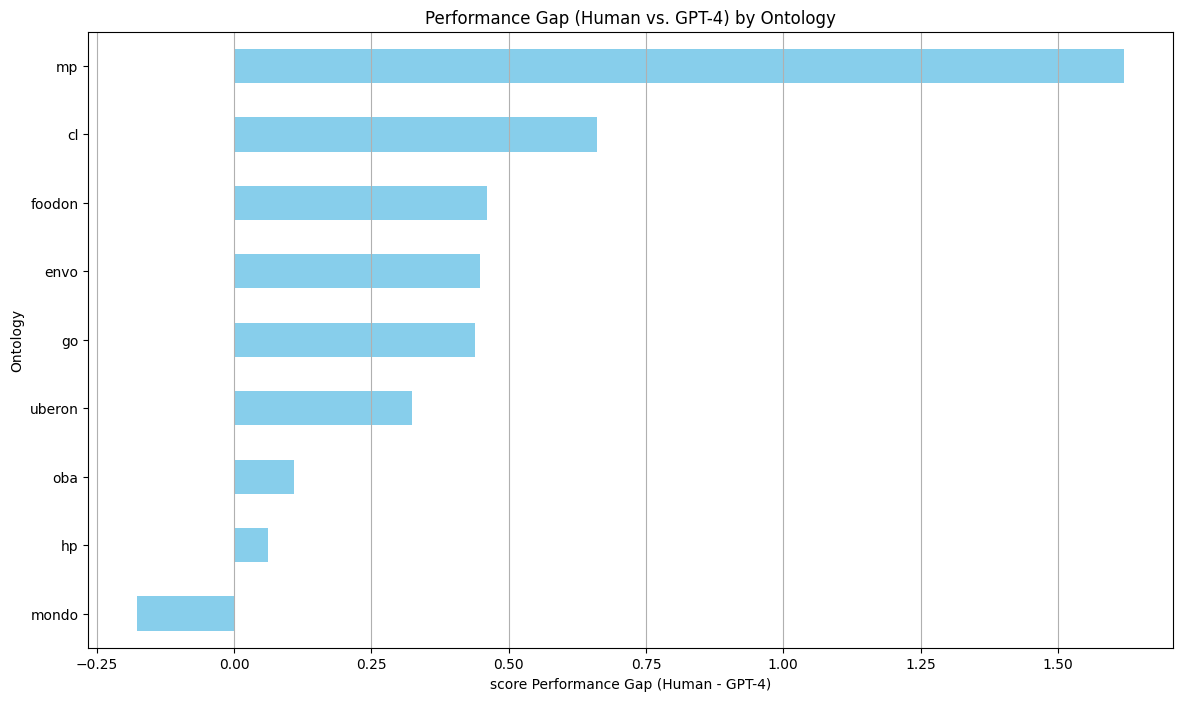

In [26]:
import matplotlib.pyplot as plt

# 1. Filter the data for the two models of interest ("human" and "gpt-4").
human_data = eval_data_base[eval_data_base['model_name'] == 'human']
gpt4_data = eval_data_base[eval_data_base['model_name'] == 'gpt-4']

def gap_by_ontology(metric="score"):
    # 2. Group the data by ontology.
    # 3. For each ontology, compute the average score of each model.
    human_avg_scores_by_ontology = human_data.groupby('ontology')[metric].mean()
    gpt4_avg_scores_by_ontology = gpt4_data.groupby('ontology')[metric].mean()
    
    # 4. Calculate the performance gap for each ontology.
    performance_gap_by_ontology = human_avg_scores_by_ontology - gpt4_avg_scores_by_ontology
    
    # 5. Plot the performance gap for each ontology.
    plt.figure(figsize=(14, 8))
    performance_gap_by_ontology.sort_values().plot(kind='barh', color='skyblue')
    plt.title('Performance Gap (Human vs. GPT-4) by Ontology')
    plt.xlabel(f'{metric} Performance Gap (Human - GPT-4)')
    plt.ylabel('Ontology')
    plt.grid(axis='x')
    plt.show()
gap_by_ontology()

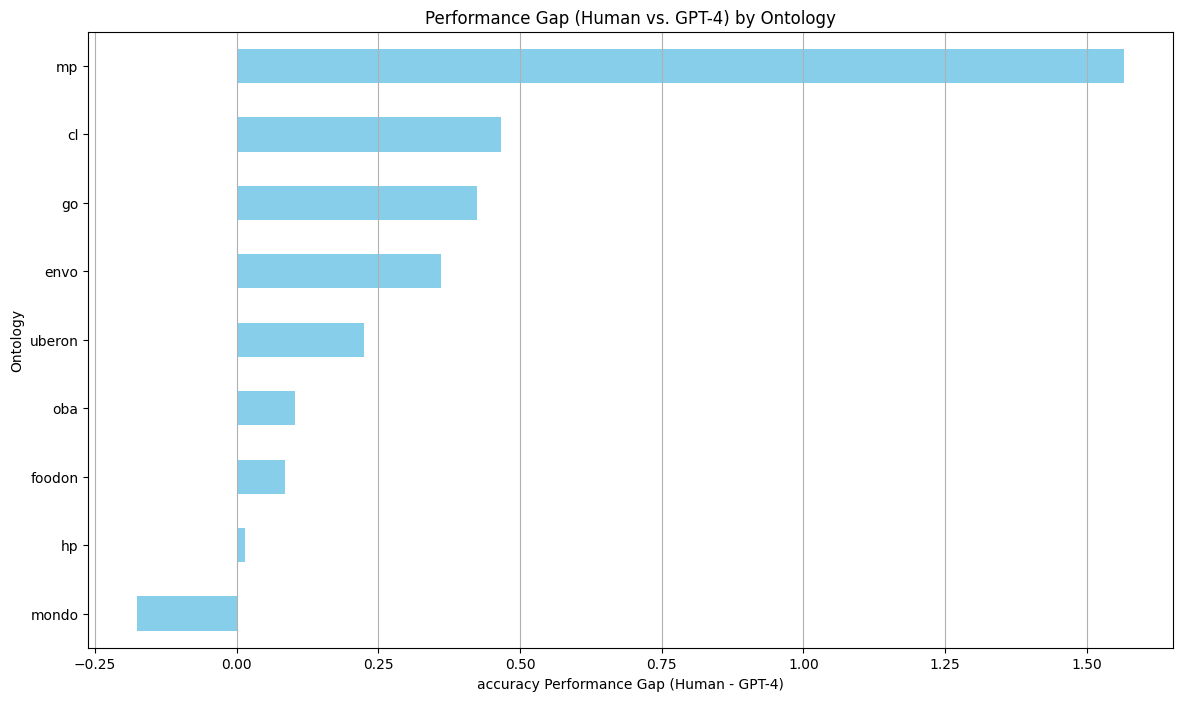

In [27]:
gap_by_ontology("accuracy")

In [28]:
pairwise_t_tests(eval_data_base.query("ontology == 'hp'"), 'accuracy')

,0,1,2,3
0,gpt-4,human,0.892802,False
1,gpt-4,gpt-3.5-turbo,0.340146,False
2,gpt-4,nous-hermes-13b,0.022073,False
3,human,gpt-3.5-turbo,0.294679,False
4,human,nous-hermes-13b,0.019081,False
5,gpt-3.5-turbo,nous-hermes-13b,0.191979,False


In [29]:
pairwise_t_tests(eval_data_base.query("ontology == 'mondo'"), 'accuracy')

,0,1,2,3
0,human,gpt-3.5-turbo,0.457280,False
1,human,nous-hermes-13b,0.534709,False
2,human,gpt-4,0.484571,False
3,gpt-3.5-turbo,nous-hermes-13b,0.019290,False
4,gpt-3.5-turbo,gpt-4,1.000000,False
5,nous-hermes-13b,gpt-4,0.022890,False


In [30]:
pairwise_t_tests(eval_data_base.query("ontology == 'hp'"), 'score')

,0,1,2,3
0,gpt-4,human,0.675384,False
1,gpt-4,gpt-3.5-turbo,0.600253,False
2,gpt-4,nous-hermes-13b,0.354175,False
3,human,gpt-3.5-turbo,0.353427,False
4,human,nous-hermes-13b,0.187778,False
5,gpt-3.5-turbo,nous-hermes-13b,0.684153,False


In [31]:
pairwise_t_tests(eval_data_base.query("ontology == 'mondo'"), 'score')

,0,1,2,3
0,human,gpt-3.5-turbo,0.559824,False
1,human,nous-hermes-13b,0.881350,False
2,human,gpt-4,0.584114,False
3,gpt-3.5-turbo,nous-hermes-13b,0.453456,False
4,gpt-3.5-turbo,gpt-4,0.953717,False
5,nous-hermes-13b,gpt-4,0.490047,False


## Differences increase as confidence decreases

In [32]:
scores_tbl(eval_data_base.query('method in ["RAG", "curator"] and confidence>4'))

method,model name,accuracy,score,consistency
RAG,gpt-3.5-turbo,4.076,3.643,3.794
RAG,gpt-4,4.029,3.606,3.794
RAG,nous-hermes-13b,3.669,3.272,3.571
curator,human,4.619,4.321,4.344


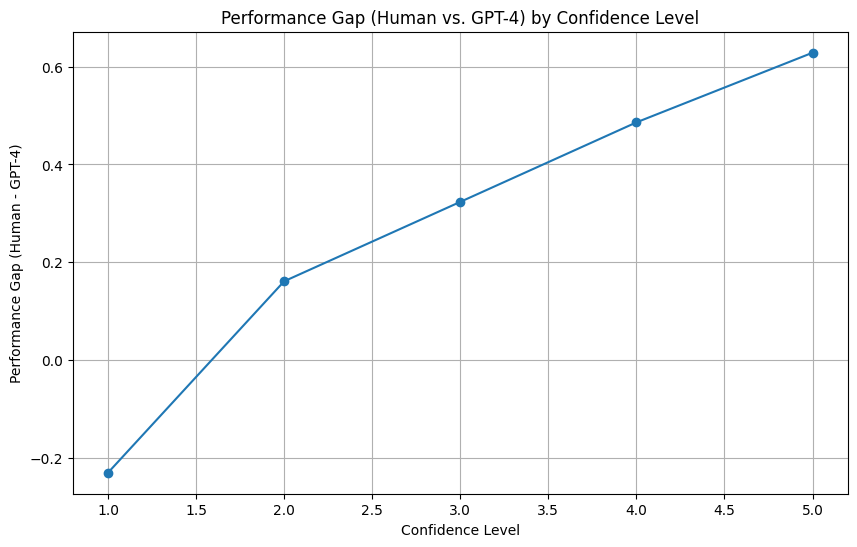

In [33]:
import matplotlib.pyplot as plt

# Filter the data for the two models of interest
human_data = eval_data_base[eval_data_base['model_name'] == 'human']
gpt4_data = eval_data_base[eval_data_base['model_name'] == 'gpt-4']

# Group by confidence level and compute the average score for each model
human_avg_scores = human_data.groupby('confidence')['score'].mean()
gpt4_avg_scores = gpt4_data.groupby('confidence')['score'].mean()

# Calculate the performance gap for each confidence level
performance_gap = human_avg_scores - gpt4_avg_scores

# Plot the performance gap against confidence levels
plt.figure(figsize=(10, 6))
performance_gap.plot(marker='o', linestyle='-')
plt.title('Performance Gap (Human vs. GPT-4) by Confidence Level')
plt.xlabel('Confidence Level')
plt.ylabel('Performance Gap (Human - GPT-4)')
plt.grid(True)
plt.savefig("results/performance-gap-vs-confidence.png")
plt.show()


In [95]:
#sns.boxplot(data=performance_gap.reset_index(), x='index', y=0)
#type(performance_gap)
#performance_gap
performance_gap.reset_index()
#sns.boxplot(data=performance_gap.reset_index(), x='confidence', y='score')
#human_data - gpt4_data

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Convert the index (confidence levels) to a series and calculate the correlation with the performance gap
correlation_gap_confidence = performance_gap.corr(pd.Series(performance_gap.index, index=performance_gap.index))

correlation_gap_confidence


0.9735670050508386

/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

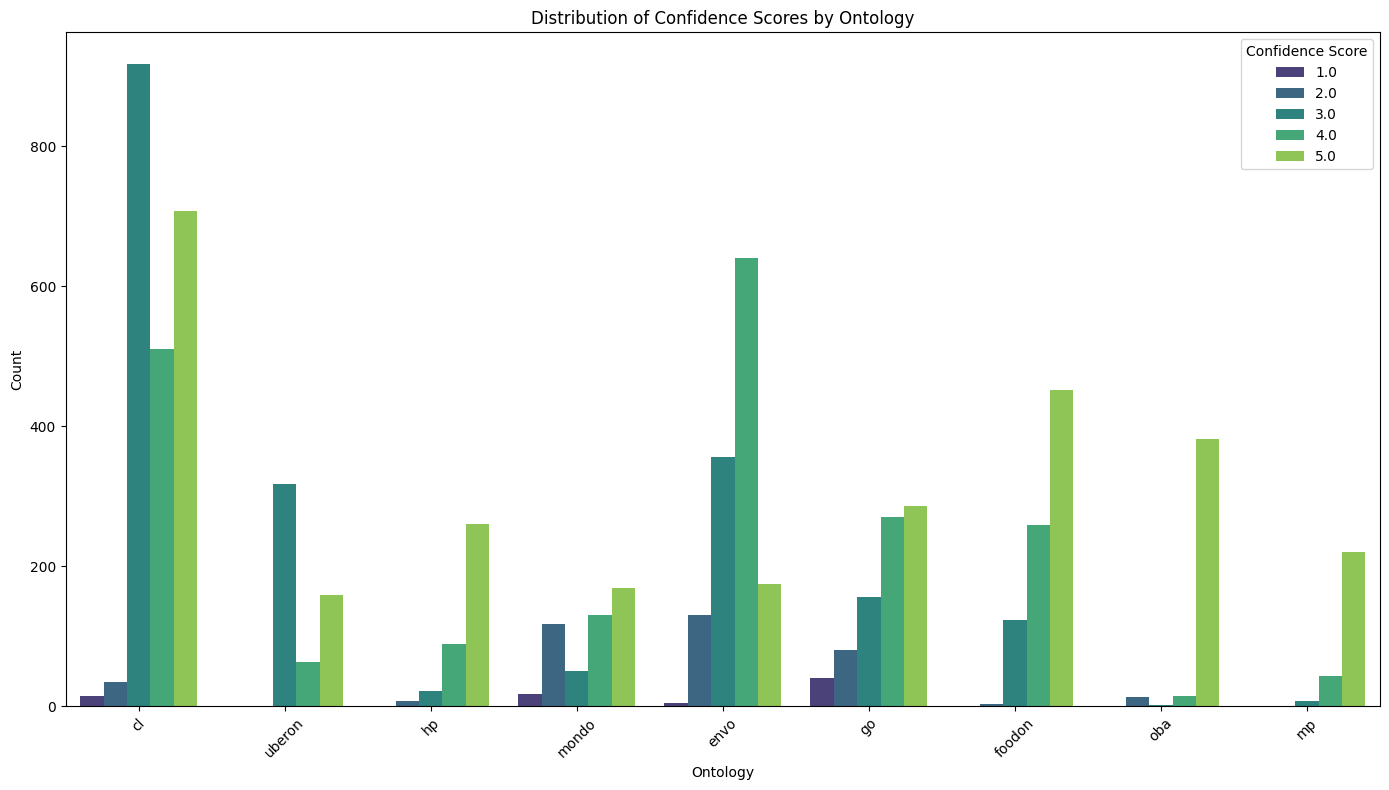

In [35]:
import seaborn as sns

# Create a bar chart to display the frequency of each confidence score for every ontology
plt.figure(figsize=(14, 8))
sns.countplot(data=eval_data, x='ontology', hue='confidence', palette="viridis")
plt.title('Distribution of Confidence Scores by Ontology')
plt.xlabel('Ontology')
plt.ylabel('Count')
plt.legend(title='Confidence Score', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Adding GitHub as background increases performance across all scores

Note that the addition of GitHub was only performed for 3 ontologies

In [36]:
eval_data_gh = eval_data.query('method in ["RAG", "RAG+github", "curator"] and ontology in ["cl", "envo", "uberon"]')
#eval_data_gh["model_method"] = eval_data_gh["method"] + "_" + eval_data_gh["model_name"]

In [37]:
scores_tbl(eval_data_gh)

method,model name,accuracy,score,consistency
RAG,gpt-3.5-turbo,3.951,3.527,3.606
RAG,gpt-4,3.967,3.537,3.681
RAG,nous-hermes-13b,4.015,3.637,3.668
RAG+github,gpt-3.5-turbo,4.132,3.669,3.680
RAG+github,gpt-4,4.192,3.762,3.849
curator,human,4.428,4.159,4.186


In [38]:
pairwise_t_tests(eval_data_gh, "score", "method")

,0,1,2,3
0,RAG,curator,2.962138e-16,True
1,RAG,RAG+github,2.837171e-03,True
2,curator,RAG+github,2.743914e-08,True


In [39]:
pairwise_t_tests(eval_data_gh, "accuracy", "method")

,0,1,2,3
0,RAG,curator,1.317711e-08,True
1,RAG,RAG+github,1.226462e-03,True
2,curator,RAG+github,2.116729e-03,True


In [40]:
pairwise_t_tests(eval_data_gh, "consistency", "method")

,0,1,2,3
0,RAG,curator,2.597665e-11,True
1,RAG,RAG+github,9.141338e-02,False
2,curator,RAG+github,3.945848e-07,True


In [41]:
eval_data.dropna(subset=["consistency", "score", "accuracy"]).groupby(['method', 'model_name'])[["accuracy", "score", "consistency"]].mean().reset_index().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

,method,model_name,accuracy,score,consistency
0,RAG,gpt-3.5-turbo,4.018,3.598,3.700
1,RAG,gpt-4,3.945,3.543,3.664
2,RAG,nous-hermes-13b,3.741,3.361,3.548
3,RAG+background,gpt-3.5-turbo,4.105,3.435,3.349
4,RAG+background,gpt-4,4.100,3.237,3.072
5,RAG+docs,gpt-3.5-turbo,4.409,3.896,3.968
6,RAG+github,gpt-3.5-turbo,4.132,3.669,3.680
7,RAG+github,gpt-4,4.192,3.762,3.849
8,curator,human,4.332,4.060,4.107
9,no_RAG,gpt-4,4.634,3.504,3.260


In [42]:
eval_data.groupby(['method', 'model_name'])[["accuracy", "score", "consistency"]].mean().reset_index().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

,method,model_name,accuracy,score,consistency
0,RAG,gpt-3.5-turbo,4.037,3.604,3.700
1,RAG,gpt-4,3.990,3.562,3.664
2,RAG,nous-hermes-13b,3.811,3.422,3.550
3,RAG+background,gpt-3.5-turbo,4.139,3.538,3.349
4,RAG+background,gpt-4,4.118,3.383,3.076
5,RAG+docs,gpt-3.5-turbo,4.417,3.778,3.968
6,RAG+github,gpt-3.5-turbo,4.179,3.719,3.680
7,RAG+github,gpt-4,4.237,3.795,3.849
8,curator,human,4.328,4.041,4.106
9,no_RAG,gpt-4,4.702,3.884,3.260


Because some values are null it's better to split this into 3 tables

In [43]:

def smry(k, this_df=eval_data):
    return this_df.dropna(subset=[k]).groupby(['method', 'model_name'])[[k]].mean().reset_index()

In [44]:
smry("score")

,method,model_name,score
0,RAG,gpt-3.5-turbo,3.604367
1,RAG,gpt-4,3.561962
2,RAG,nous-hermes-13b,3.422491
3,RAG+background,gpt-3.5-turbo,3.537671
4,RAG+background,gpt-4,3.382601
5,RAG+docs,gpt-3.5-turbo,3.777778
6,RAG+github,gpt-3.5-turbo,3.718681
7,RAG+github,gpt-4,3.794702
8,curator,human,4.040658
9,no_RAG,gpt-4,3.883978


In [45]:
smry("accuracy")

,method,model_name,accuracy
0,RAG,gpt-3.5-turbo,4.037004
1,RAG,gpt-4,3.990205
2,RAG,nous-hermes-13b,3.811111
3,RAG+background,gpt-3.5-turbo,4.138686
4,RAG+background,gpt-4,4.118474
5,RAG+docs,gpt-3.5-turbo,4.417040
6,RAG+github,gpt-3.5-turbo,4.178808
7,RAG+github,gpt-4,4.237251
8,curator,human,4.327968
9,no_RAG,gpt-4,4.701657


In [46]:
smry("consistency")

,method,model_name,consistency
0,RAG,gpt-3.5-turbo,3.700130
1,RAG,gpt-4,3.664093
2,RAG,nous-hermes-13b,3.550201
3,RAG+background,gpt-3.5-turbo,3.349442
4,RAG+background,gpt-4,3.075843
5,RAG+docs,gpt-3.5-turbo,3.967532
6,RAG+github,gpt-3.5-turbo,3.680451
7,RAG+github,gpt-4,3.849057
8,curator,human,4.106414
9,no_RAG,gpt-4,3.260163


In [47]:
# 1. Load the data
eval_df_direct = eval_data

# 2. Group by ontology, method, and model_name and compute the average scores
grouped_df_direct = eval_df_direct.groupby(['ontology', 'method', 'model_name']).agg({
    'accuracy': 'mean',
    'consistency': 'mean',
    'score': 'mean'
}).reset_index()

# 3. Pivot the table to create a multi-level column header
pivoted_multiindex_direct = grouped_df_direct.set_index(['method', 'model_name', 'ontology']).unstack('ontology')

# 4. Display the MultiIndex table with average scores
pivoted_multiindex_direct.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)


In [48]:
pivoted_multiindex_direct.dropna().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [49]:
eval_data=subset
summary_data = eval_data.groupby(['method', 'model_name']).agg(
    mean_accuracy=('accuracy', 'mean'),
    mean_consistency=('consistency', 'mean'),
    mean_score=('score', 'mean')
).reset_index()

# Step 3: Find the top-performing method for each criterion
top_accuracy_method = summary_data.loc[summary_data['mean_accuracy'].idxmax(), ['method', 'model_name', 'mean_accuracy']]
top_consistency_method = summary_data.loc[summary_data['mean_consistency'].idxmax(), ['method', 'model_name', 'mean_consistency']]
top_score_method = summary_data.loc[summary_data['mean_score'].idxmax(), ['method', 'model_name', 'mean_score']]

# Step 4: Create a table with the top-performing methods
top_methods_table = pd.DataFrame([top_accuracy_method, top_consistency_method, top_score_method], index=['Top Accuracy', 'Top Internal Consistency', 'Top Score'])

# Step 5: Display the table
print(top_methods_table)



                           method model_name  mean_accuracy  mean_consistency  \
Top Accuracy               no_RAG      gpt-4       4.701657               NaN   
Top Internal Consistency  curator      human            NaN          4.106414   
Top Score                 curator      human            NaN               NaN   

                          mean_score  
Top Accuracy                     NaN  
Top Internal Consistency         NaN  
Top Score                   4.040658  


In [50]:
eval_data.groupby(['method', 'model_name', 'ontology']).size()

method          model_name       ontology
RAG             gpt-3.5-turbo    cl          222
                                 envo        160
                                 foodon      175
                                 go          173
                                 hp           96
                                 mondo        94
                                 mp           67
                                 oba          92
                                 uberon       66
                gpt-4            cl          229
                                 envo        164
                                 foodon      174
                                 go          178
                                 hp           95
                                 mondo        94
                                 mp           68
                                 oba          92
                                 uberon       68
                nous-hermes-13b  cl          227
                           

## Effects of including GitHub as a background source

We only used github as an additional background for cl and envo (and uberon, but insufficient evaluations here)

In [51]:
cl_envo = eval_data.query("ontology == 'cl' or ontology == 'envo'")
smry("consistency", cl_envo)

,method,model_name,consistency
0,RAG,gpt-3.5-turbo,3.523404
1,RAG,gpt-4,3.604167
2,RAG,nous-hermes-13b,3.650862
3,RAG+background,gpt-3.5-turbo,3.288136
4,RAG+background,gpt-4,3.402597
5,RAG+docs,gpt-3.5-turbo,3.967532
6,RAG+github,gpt-3.5-turbo,3.610169
7,RAG+github,gpt-4,3.796610
8,curator,human,4.145923
9,no_RAG,gpt-4,3.260163


In [52]:
smry("score", cl_envo)

,method,model_name,score
0,RAG,gpt-3.5-turbo,3.476440
1,RAG,gpt-4,3.498728
2,RAG,nous-hermes-13b,3.639842
3,RAG+background,gpt-3.5-turbo,3.605670
4,RAG+background,gpt-4,3.653543
5,RAG+docs,gpt-3.5-turbo,3.777778
6,RAG+github,gpt-3.5-turbo,3.627907
7,RAG+github,gpt-4,3.705426
8,curator,human,4.023136
9,no_RAG,gpt-4,3.883978


In [53]:
smry("accuracy", cl_envo)

,method,model_name,accuracy
0,RAG,gpt-3.5-turbo,3.905512
1,RAG,gpt-4,3.943590
2,RAG,nous-hermes-13b,4.042440
3,RAG+background,gpt-3.5-turbo,4.194301
4,RAG+background,gpt-4,4.261905
5,RAG+docs,gpt-3.5-turbo,4.417040
6,RAG+github,gpt-3.5-turbo,4.088312
7,RAG+github,gpt-4,4.153247
8,curator,human,4.304910
9,no_RAG,gpt-4,4.701657


In [54]:
grouped_data_stats = eval_data.groupby(['method', 'model_name'], as_index=False).agg({
    'accuracy': ['mean', 'std', 'count'],
    'consistency': ['mean', 'std', 'count'],
    'score': ['mean', 'std', 'count']
})
grouped_data_stats

method       model_name  accuracy                 consistency  \
                                        mean       std count        mean   
0             RAG    gpt-3.5-turbo  4.037004  1.115499  1108    3.700130   
1             RAG            gpt-4  3.990205  1.130083  1123    3.664093   
2             RAG  nous-hermes-13b  3.811111  1.245368  1080    3.550201   
3  RAG+background    gpt-3.5-turbo  4.138686  0.974993  1096    3.349442   
4  RAG+background            gpt-4  4.118474  1.002519   996    3.075843   
5        RAG+docs    gpt-3.5-turbo  4.417040  1.013902   223    3.967532   
6      RAG+github    gpt-3.5-turbo  4.178808  1.133282   453    3.680451   
7      RAG+github            gpt-4  4.237251  1.030226   451    3.849057   
8         curator            human  4.327968  0.885762   994    4.106414   
9          no_RAG            gpt-4  4.701657  0.640701   181    3.260163   

                      score                  
        std count      mean       std count  
0  1.131688   767  3.604367  1.175871  1145  
1  1.102556   777  3.561962  1.150231  1162  
2  1.170955   747  3.422491  1.225311  1116  
3  1.122440   807  3.537671  1.111729  1168  
4  1.142396   712  3.382601  1.150849  1069  
5  1.157069   154  3.777778  1.131704   225  
6  1.215991   266  3.718681  1.166711   455  
7  1.164439   265  3.794702  1.066285   453  
8  0.888887   686  4.040658  0.964632  1033  
9  0.797921   123  3.883978  1.039668   181

## Summary Barcharts

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


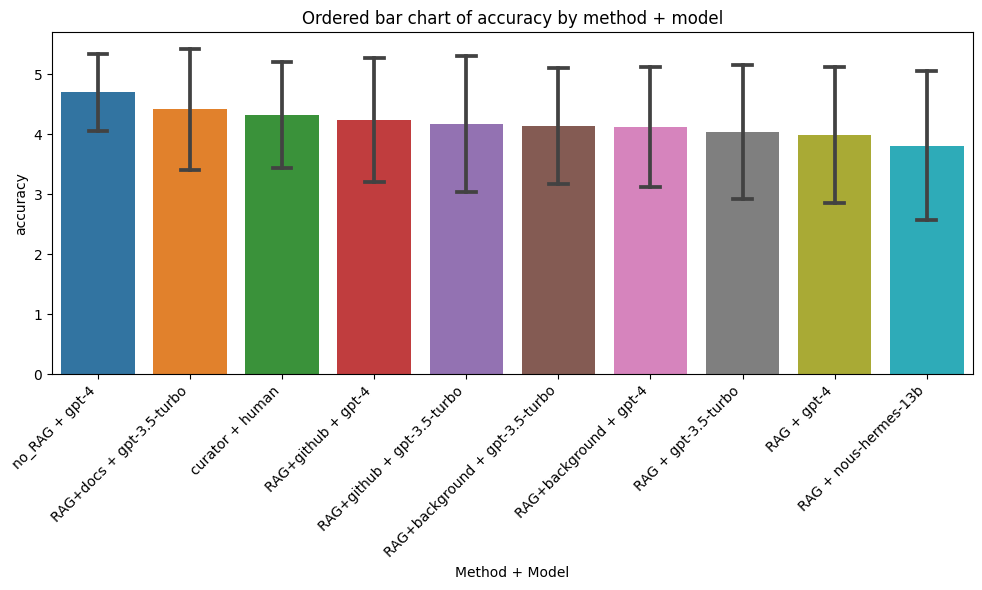

/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


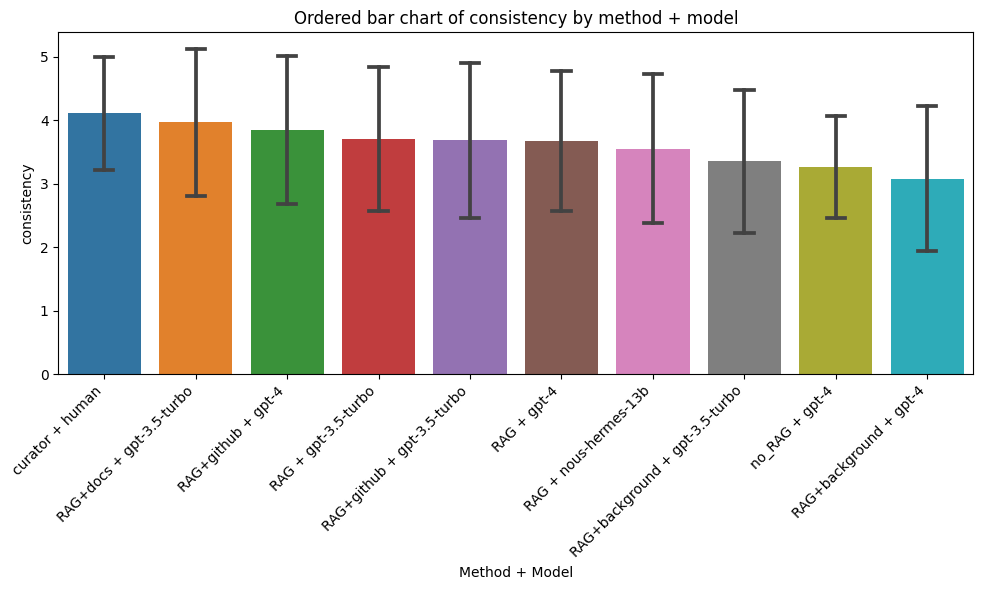

/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cjm/Library/Caches/pypoetry/virtualenvs/gpt-ontology-completion-analysis-LiQZhntW-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


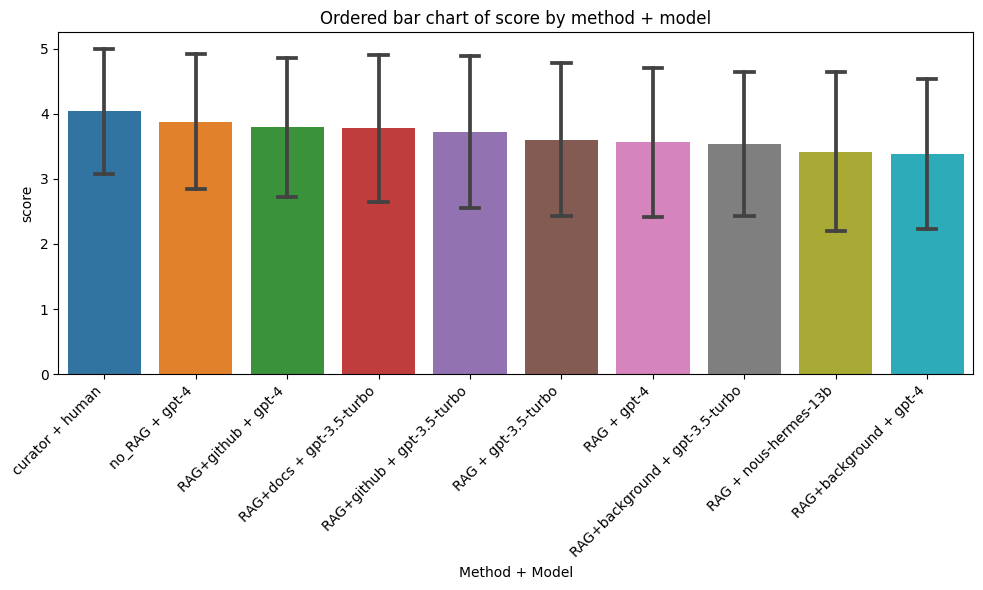

In [56]:
metrics = ['accuracy', 'consistency', 'score']

# Combine 'method' and 'model_name' to create a new column for the x-axis
eval_data['method_model'] = eval_data['method'] + ' + ' + eval_data['model_name']

def plot_metric(metric, data, save=False):
    # Calculate the average for ordering
    order = data.groupby('method_model')[metric].mean().sort_values(ascending=False).index
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=data,
        x='method_model',
        y=metric,
        order=order,  # Ordering the x-axis based on the average value of the metric
        capsize=.2,  # Adding error bars
        errorbar='sd'  # Using standard deviation for error bars
    )
    plt.title(f'Ordered bar chart of {metric} by method + model')
    plt.ylabel(f'{metric}')
    plt.xlabel('Method + Model')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"results/definition-eval-figure-{metric}.png")
    plt.show()

for metric in metrics:
    plot_metric(metric, eval_data, True)


/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/58816721.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/58816721.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/58816721.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')


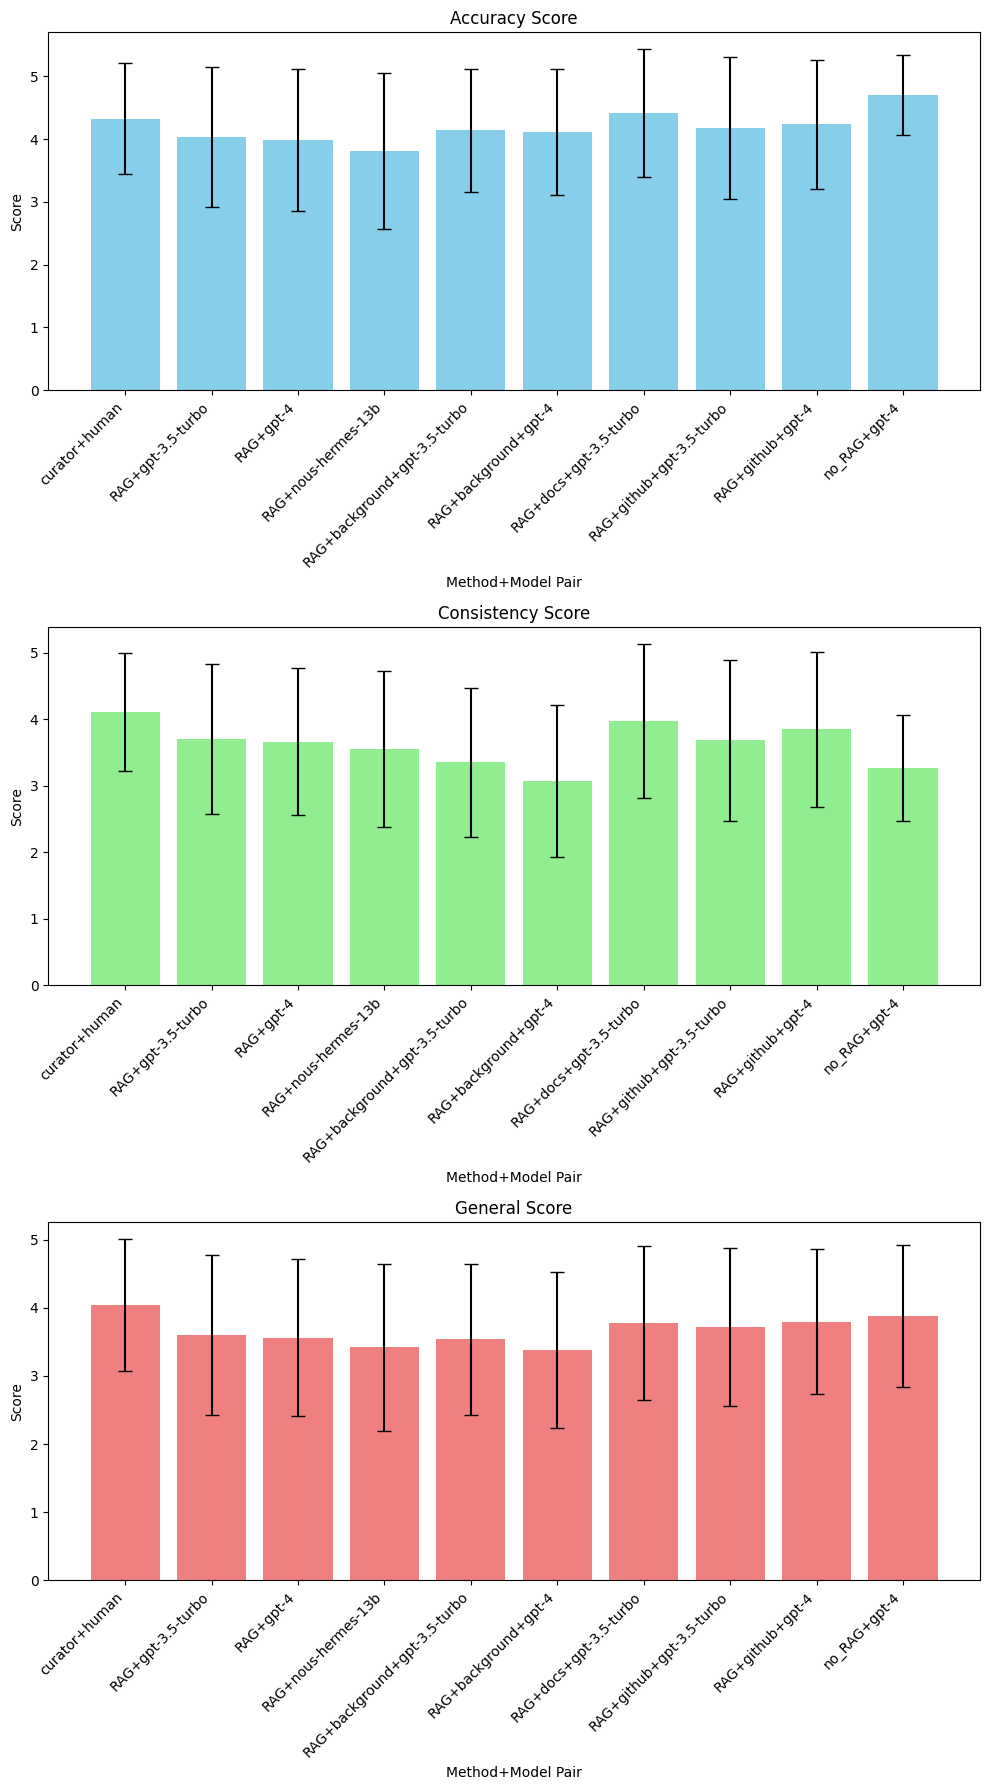

In [57]:
def scorecharts(eval_data):
    # Grouping the data by method and model_name and calculating the mean and standard deviation of the scores
    grouped_data_stats = eval_data.groupby(['method', 'model_name'], as_index=False).agg({
        'accuracy': ['mean', 'std'],
        'consistency': ['mean', 'std'],
        'score': ['mean', 'std']
    })
    
    # Creating a new column to represent method+model pair
    grouped_data_stats['method_model'] = grouped_data_stats['method'] + '+' + grouped_data_stats['model_name']
    
    # Separating the 'curator' rows from the data
    curator_rows = grouped_data_stats[grouped_data_stats['method'] == 'curator']
    
    # Separating the non-'curator' rows from the data
    non_curator_rows = grouped_data_stats[grouped_data_stats['method'] != 'curator']
    
    # Concatenating the 'curator' rows at the beginning
    ordered_data_stats = pd.concat([curator_rows, non_curator_rows], ignore_index=True)
    
    # Plotting bar charts for each score type with error bars
    fig, ax = plt.subplots(3, 1, figsize=(10, 18))
    
    # Plotting bar chart for accuracy score with error bars
    ax[0].bar(ordered_data_stats['method_model'], ordered_data_stats['accuracy']['mean'], 
              yerr=ordered_data_stats['accuracy']['std'], color='skyblue', capsize=5)
    ax[0].set_title('Accuracy Score')
    ax[0].set_ylabel('Score')
    ax[0].set_xlabel('Method+Model Pair')
    ax[0].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
    
    # Plotting bar chart for consistency score with error bars
    ax[1].bar(ordered_data_stats['method_model'], ordered_data_stats['consistency']['mean'], 
              yerr=ordered_data_stats['consistency']['std'], color='lightgreen', capsize=5)
    ax[1].set_title('Consistency Score')
    ax[1].set_ylabel('Score')
    ax[1].set_xlabel('Method+Model Pair')
    ax[1].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
    
    # Plotting bar chart for general score with error bars
    ax[2].bar(ordered_data_stats['method_model'], ordered_data_stats['score']['mean'], 
              yerr=ordered_data_stats['score']['std'], color='lightcoral', capsize=5)
    ax[2].set_title('General Score')
    ax[2].set_ylabel('Score')
    ax[2].set_xlabel('Method+Model Pair')
    ax[2].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
    
    # Adjusting the layout to prevent overlap
    plt.tight_layout()

# Display the plots

scorecharts(eval_data)
plt.savefig("results/definition-eval-figure.png")
plt.show()

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/58816721.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/58816721.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/58816721.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(ordered_data_stats['method_model'], rotation=45, ha='right')


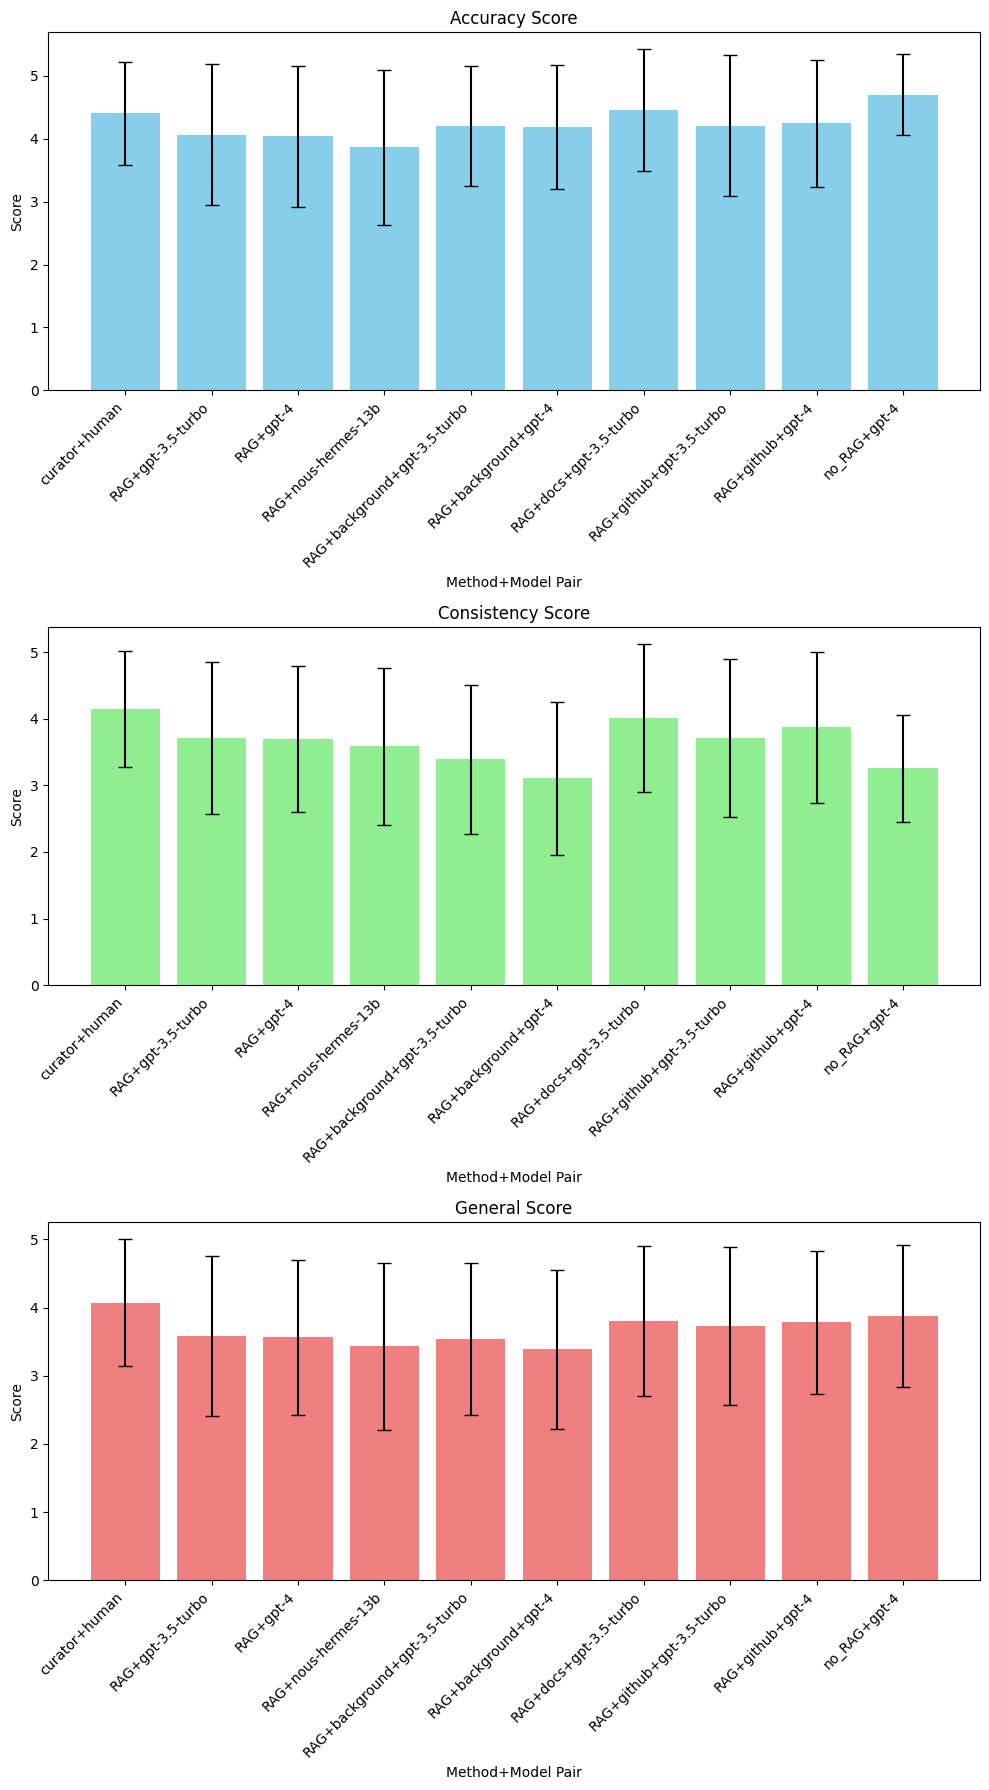

In [58]:
scorecharts(eval_data.query("confidence > 2.0"))

## Effect of github

In [59]:
from scipy.stats import ttest_ind


In [60]:
def compare_methods(method1, method2, model="gpt-4", metric="consistency"):

    scores1 = eval_data[(eval_data['method'] == method1)]
    if model and method1 != "curator":
        scores1 = scores1[scores1['model_name'] == model]
    scores1 = scores1[metric]
    scores2 = eval_data[(eval_data['method'] == method2)]
    if model:
        scores2 = scores2[scores2['model_name'] == model]
    scores2 = scores2[metric]

    # Conducting the t-test
    t_stat_bg, p_value_bg = ttest_ind(scores1.dropna(), scores2.dropna())

    return t_stat_bg, p_value_bg


compare_methods("RAG", "RAG+github")

(-2.324428557874594, 0.02029438192415039)

In [61]:
compare_methods("RAG", "RAG+github", None)

(-2.2730654696013204, 0.023097146394324797)

In [62]:
compare_methods("RAG", "RAG+github", "gpt-3.5-turbo")

(0.23966895233425534, 0.8106345447903158)

In [63]:
compare_methods("RAG", "RAG+github", metric="score")

(-3.7271994083117117, 0.00020030184814198002)

In [64]:
compare_methods("RAG", "RAG+github", metric="accuracy")

(-4.019806814536966, 6.1003062210610434e-05)

In [65]:
compare_methods("curator", "no_RAG", metric="score")

(1.9919669302211247, 0.04659875066991915)

In [66]:
compare_methods("curator", "no_RAG", metric="accuracy")

(-5.422583358110355, 7.128246015185536e-08)

In [67]:
compare_methods("curator", "RAG", metric="score")

(10.492140906914484, 3.6625449293917967e-25)

In [68]:
compare_methods("curator", "RAG+github", metric="score")

(4.379117429174212, 1.27510607080188e-05)

In [69]:
compare_methods("curator", "RAG+github", metric="consistency")

(3.6554241462393593, 0.00027084810132955745)

## Inter-evaluation consistency

The data contains various columns, including accuracy, consistency, and score, which are the scoring metrics for which we need to calculate inter-evaluator consistency. The scores are continuous, and there are multiple evaluators, which makes the Intraclass Correlation Coefficient (ICC) a suitable measure for assessing inter-evaluator consistency.

Let's proceed to calculate the ICC for each of the three metrics (accuracy, consistency, score). ICC values typically range from 0 to 1, where 0.75≤ICC<0.9 indicates good reliability.

In [70]:
eval_data["confidence"].unique()

array([ 3.,  4.,  5.,  2.,  1., nan])

In [71]:
pd.options.mode.chained_assignment = None  # default='warn'

import statsmodels.api as sm
from statsmodels.formula.api import ols

def calculate_icc_oneway(data, metric):
    # Removing rows with missing values in the specified metric
    data = data[['evaluator', 'label', metric]].dropna()
    # Fitting the one-way ANOVA model
    model = ols(f'{metric} ~ C(evaluator)', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=1)
    
    # Getting the mean squares
    msb = anova_table['sum_sq'].iloc[0] / anova_table['df'].iloc[0]
    mse = anova_table['sum_sq'].iloc[1] / anova_table['df'].iloc[1]
    
    # Number of ratings per target
    k = len(data['evaluator'].unique())
    
    # Calculating ICC(1,1)
    icc = (msb - mse) / (msb + (k - 1) * mse)
    
    return icc

def calculate_all_icc(data, min_confidence=0):
    data = data[data['confidence'] > min_confidence]
    # Calculating ICC for 'accuracy', 'consistency', and 'score'
    icc_accuracy = calculate_icc_oneway(data, 'accuracy')
    icc_consistency = calculate_icc_oneway(data, 'consistency')
    icc_score = calculate_icc_oneway(data, 'score')

    return icc_accuracy, icc_consistency, icc_score

calculate_all_icc(eval_data)


(0.8092312105497903, 0.736716828618239, 0.7716798937809258)

In [72]:

calculate_all_icc(eval_data, 3.0)

(0.6639831209534698, 0.667035443903115, 0.6419573858522452)

In [73]:
rows = []
for ontology in eval_data["ontology"].unique():
    data = eval_data[eval_data["ontology"] == ontology]
    icc = calculate_all_icc(data)
    print(ontology, len(data["evaluator"].unique()), icc)
    rows.append({"ontology":ontology, "num_evaluators": len(data["evaluator"].unique()),
                 "accuracy":icc[0], "consistency":icc[1], "score":icc[2]})
icc_by_ont = pd.DataFrame(rows)
icc_by_ont

cl 10 (0.8796040057470264, 0.6981613263852124, 0.841629668118427)
uberon 2 (0.9870038673528775, nan, 0.8047784293884301)
hp 2 (0.6350517524774699, nan, 0.9575187803024993)
mondo 2 (0.9463508740766555, 0.9046201710099028, 0.9318993114427069)
envo 3 (0.9320579739449903, nan, 0.9712468255965644)
go 4 (0.30276894911662067, 0.8626432952162885, 0.1929912873231871)
foodon 5 (0.9555149224136797, 0.8549565526856056, 0.921410365296325)
oba 2 (0.9288652082187571, 0.9891247841426452, 0.9568098625167993)
mp 2 (0.4149337436961458, 0.9485688600165647, -0.5410936564474674)


/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/3171159856.py:14: RuntimeWarning: invalid value encountered in scalar divide
  msb = anova_table['sum_sq'].iloc[0] / anova_table['df'].iloc[0]
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/3171159856.py:14: RuntimeWarning: invalid value encountered in scalar divide
  msb = anova_table['sum_sq'].iloc[0] / anova_table['df'].iloc[0]
/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_68869/3171159856.py:14: RuntimeWarning: invalid value encountered in scalar divide
  msb = anova_table['sum_sq'].iloc[0] / anova_table['df'].iloc[0]


,ontology,num_evaluators,accuracy,consistency,score
0,cl,10,0.879604,0.698161,0.841630
1,uberon,2,0.987004,NaN,0.804778
2,hp,2,0.635052,NaN,0.957519
3,mondo,2,0.946351,0.904620,0.931899
4,envo,3,0.932058,NaN,0.971247
5,go,4,0.302769,0.862643,0.192991
6,foodon,5,0.955515,0.854957,0.921410
7,oba,2,0.928865,0.989125,0.956810
8,mp,2,0.414934,0.948569,-0.541094


In [74]:
go = eval_data[eval_data["ontology"] == "go"]

In [75]:
go

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
4858,bb1e6c76c178daba37fbc45d1bd4baff4d47be80c22ed2...,go,radial spoke 1,A component of the radial spoke complex that i...,4.0,NaN,4.0,3.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
4859,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,go,radial spoke 1,A component of the radial spoke complex that i...,5.0,3.0,3.0,2.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
4860,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,go,radial spoke 1,A component of the radial spoke complex that i...,3.0,3.0,3.0,NaN,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
4861,d1525b556eb9ee23947be85c87445db74734dd3420272d...,go,radial spoke 1,A component of the radial spoke complex that i...,3.0,2.0,2.0,5.0,RAG+background,gpt-3.5-turbo,does not explain,RAG+background + gpt-3.5-turbo
4862,bb1e6c76c178daba37fbc45d1bd4baff4d47be80c22ed2...,go,radial spoke 1,The radial spoke of each group of radial spoke...,4.0,NaN,4.0,3.0,curator,human,"unclear what is the ""1"" versus ""2""",curator + human
...,...,...,...,...,...,...,...,...,...,...,...,...
7285,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,go,protein-glutathione oxidoreductase (glutathion...,The enzymatic process that involves the transf...,5.0,4.0,4.0,3.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
7286,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,go,protein-glutathione oxidoreductase (glutathion...,The enzymatic process that involves the transf...,4.0,2.0,4.0,2.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
7288,4effca6dc63f05c6cf442e57886dc321f21a1f4cf3173d...,go,non-canonical inflammasome complex,"An inflammasome complex containing CASP4, know...",2.0,2.0,2.0,1.0,curator,human,NaN,curator + human
7289,19d9efa3d570f1e881d24765d6fec9e9251d94ca0fa755...,go,non-canonical inflammasome complex,"An inflammasome complex containing CASP4, know...",5.0,NaN,5.0,1.0,curator,human,NaN,curator + human


## Inconsistent definition scoring

Here we hone in on specific examples of definitions that have been scored differently

In [76]:
def inconsistent_scores(data, metric="score", min_confidence=0):
    data = data[data["confidence"] > min_confidence]
    score_std = data.groupby(["definition"])[metric].std(numeric_only=True).reset_index().dropna()
    score_std = score_std.sort_values(by=metric, ascending=False)
    defns = score_std[0:20]['definition'].unique()
    return data[data["definition"].isin(defns)]
    
    

#score_std = eval_data.groupby(["definition"])["score"].std(numeric_only=True).reset_index().dropna()
#score_std = score_std.sort_values(by="score", ascending=False)
inconsistent_scores(eval_data)

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
1294,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,5.0,NaN,5.0,3.0,RAG,nous-hermes-13b,NaN,RAG + nous-hermes-13b
1295,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,1.0,3.0,1.0,5.0,RAG,nous-hermes-13b,"It is not defining basal cells, but the submuc...",RAG + nous-hermes-13b
1296,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,5.0,4.0,5.0,5.0,RAG,nous-hermes-13b,NaN,RAG + nous-hermes-13b
2228,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,uberon,calf,"A calf is an anatomical structure, which is a ...",5.0,NaN,5.0,3.0,RAG+background,gpt-4,NaN,RAG+background + gpt-4
2229,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,uberon,calf,"A calf is an anatomical structure, which is a ...",2.0,2.0,2.0,5.0,RAG+background,gpt-4,NaN,RAG+background + gpt-4
2230,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,uberon,calf,"A young bovine animal, specifically a young do...",5.0,NaN,5.0,3.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
2231,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,uberon,calf,"A young bovine animal, specifically a young do...",1.0,1.0,1.0,5.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
2234,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,uberon,front hindlimb zeugopod,The frontal aspect of the lower extremity that...,5.0,NaN,2.0,3.0,curator,human,NaN,curator + human
2235,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,uberon,front hindlimb zeugopod,The frontal aspect of the lower extremity that...,5.0,5.0,5.0,5.0,curator,human,NaN,curator + human
2256,cc8844298c08e2fb7ba75080b9fad6fbd23d63bf3534c7...,uberon,skin of calf,Specific portion of an animal's or human's bod...,5.0,NaN,5.0,3.0,RAG+background,gpt-4,NaN,RAG+background + gpt-4


In [77]:
inconsistent_scores(eval_data, min_confidence=4.0)

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
976,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,umbrella cell of urothelium,An umbrella cell that is part of the urothelium.,2.0,NaN,1.0,5.0,RAG+docs,gpt-3.5-turbo,Reiterates the label,RAG+docs + gpt-3.5-turbo
979,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,umbrella cell of urothelium,An umbrella cell that is part of the urothelium.,5.0,5.0,5.0,5.0,RAG+docs,gpt-3.5-turbo,NaN,RAG+docs + gpt-3.5-turbo
1171,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,lung megakaryocyte,A lung megakaryocyte is a large connective tis...,3.0,2.0,1.0,5.0,no_RAG,gpt-4,megakaryocytes are not connective tissue cells,no_RAG + gpt-4
1173,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,lung megakaryocyte,A lung megakaryocyte is a large connective tis...,5.0,5.0,5.0,5.0,no_RAG,gpt-4,NaN,no_RAG + gpt-4
1174,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,lung megakaryocyte,A lung megakaryocyte is a large connective tis...,5.0,4.0,5.0,5.0,no_RAG,gpt-4,NaN,no_RAG + gpt-4
1295,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,1.0,3.0,1.0,5.0,RAG,nous-hermes-13b,"It is not defining basal cells, but the submuc...",RAG + nous-hermes-13b
1296,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,5.0,4.0,5.0,5.0,RAG,nous-hermes-13b,NaN,RAG + nous-hermes-13b
1340,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,lung perichondrial fibroblast,A lung perichondrial fibroblast.,1.0,1.0,1.0,5.0,RAG,gpt-3.5-turbo,NaN,RAG + gpt-3.5-turbo
1341,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,lung perichondrial fibroblast,A lung perichondrial fibroblast.,5.0,4.0,5.0,5.0,RAG,gpt-3.5-turbo,The definition is the same as the label.,RAG + gpt-3.5-turbo
1656,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,"lung resident memory CD4-positive, alpha-beta ...",An alpha-beta CD4 T cell that resides in the l...,2.0,3.0,2.0,5.0,curator,human,definition misses key feature of being a memor...,curator + human


In [78]:
inconsistent_scores(eval_data, metric="accuracy", min_confidence=4.0)

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
320,e66016570cfafca08140913fe701f02954a11fde7f8660...,cl,late spermatid,"A late stage of sperm development, characteriz...",4.0,3.0,3.0,5.0,RAG,nous-hermes-13b,"stage, not cell, but interesting structural def.",RAG + nous-hermes-13b
327,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,late spermatid,"A late stage of sperm development, characteriz...",1.0,1.0,1.0,5.0,RAG,nous-hermes-13b,Describes a stage rather than a cell type.,RAG + nous-hermes-13b
527,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,glandular endometrial ciliated epithelial cell,An epithelial cell found in the glandular regi...,2.0,NaN,2.0,5.0,RAG+background,gpt-3.5-turbo,This is vague,RAG+background + gpt-3.5-turbo
529,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,cl,glandular endometrial ciliated epithelial cell,An epithelial cell found in the glandular regi...,5.0,5.0,5.0,5.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
936,ef07b359570add31929a5422d400b16c7c84e35644cb2e...,cl,umbrella cell of urothelium,A cell that is part of the urothelium and is k...,2.0,NaN,2.0,5.0,RAG,gpt-4,Just reiterating the label,RAG + gpt-4
939,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,umbrella cell of urothelium,A cell that is part of the urothelium and is k...,5.0,3.0,4.0,5.0,RAG,gpt-4,NaN,RAG + gpt-4
1201,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,lung megakaryocyte,A type of connective tissue cell found in the ...,1.0,2.0,1.0,5.0,RAG+background,gpt-3.5-turbo,megakaryocytes are not connective tissue cells,RAG+background + gpt-3.5-turbo
1203,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,lung megakaryocyte,A type of connective tissue cell found in the ...,5.0,3.0,4.0,5.0,RAG+background,gpt-3.5-turbo,It is choosing the wrong genus,RAG+background + gpt-3.5-turbo
1204,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,lung megakaryocyte,A type of connective tissue cell found in the ...,5.0,4.0,5.0,5.0,RAG+background,gpt-3.5-turbo,NaN,RAG+background + gpt-3.5-turbo
1295,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,airway submucosal gland duct basal cell,A submucosal gland found in a respiratory trac...,1.0,3.0,1.0,5.0,RAG,nous-hermes-13b,"It is not defining basal cells, but the submuc...",RAG + nous-hermes-13b


In [79]:
inconsistent_scores(eval_data, metric="consistency", min_confidence=4.0)

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
1077,b90bb4731ecc409aa579999f389d46cfbef942820f6e07...,cl,retinal astrocyte,An astrocyte that is part of the retina [Autom...,4.0,5.0,4.0,5.0,RAG+github,gpt-3.5-turbo,NaN,RAG+github + gpt-3.5-turbo
1078,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,retinal astrocyte,An astrocyte that is part of the retina [Autom...,5.0,1.0,1.0,5.0,RAG+github,gpt-3.5-turbo,It should not say [Automatically generated def...,RAG+github + gpt-3.5-turbo
1079,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,retinal astrocyte,An astrocyte that is part of the retina [Autom...,5.0,3.0,4.0,5.0,RAG+github,gpt-3.5-turbo,Contains irrelevant machine-generated informat...,RAG+github + gpt-3.5-turbo
1340,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,lung perichondrial fibroblast,A lung perichondrial fibroblast.,1.0,1.0,1.0,5.0,RAG,gpt-3.5-turbo,NaN,RAG + gpt-3.5-turbo
1341,23e1361508b2e90fbeebdc9785d3650d88d22da5911d52...,cl,lung perichondrial fibroblast,A lung perichondrial fibroblast.,5.0,4.0,5.0,5.0,RAG,gpt-3.5-turbo,The definition is the same as the label.,RAG + gpt-3.5-turbo
1688,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,"lung resident memory CD4-positive, alpha-beta ...",An alpha-beta CD4 T cell that resides in the l...,2.0,2.0,2.0,5.0,RAG+github,gpt-3.5-turbo,"lacks proper Aristotelean form, and has extran...",RAG+github + gpt-3.5-turbo
1689,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,"lung resident memory CD4-positive, alpha-beta ...",An alpha-beta CD4 T cell that resides in the l...,5.0,5.0,5.0,5.0,RAG+github,gpt-3.5-turbo,NaN,RAG+github + gpt-3.5-turbo
1720,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,"lung resident memory CD8-positive, alpha-beta ...","A lung resident memory CD8-positive, alpha-bet...",4.0,2.0,2.0,5.0,RAG,nous-hermes-13b,definition is redundant,RAG + nous-hermes-13b
1721,11490c9f46a108102de1af6c416deaa0686e9295d16c67...,cl,"lung resident memory CD8-positive, alpha-beta ...","A lung resident memory CD8-positive, alpha-bet...",5.0,5.0,5.0,5.0,RAG,nous-hermes-13b,NaN,RAG + nous-hermes-13b
1728,70ba33708cbfb103f1a8e34afef333ba7dc021022b2d9a...,cl,"lung resident memory CD8-positive, alpha-beta ...",An alpha-beta CD8 T cell that resides in the l...,2.0,2.0,2.0,5.0,RAG+github,gpt-3.5-turbo,"lacks proper Aristotelean form, and has extran...",RAG+github + gpt-3.5-turbo


In [80]:
inconsistent_scores(eval_data.query("method == 'curator' and ontology == 'mp'"), metric="accuracy")

,evaluator,ontology,label,definition,accuracy,consistency,score,confidence,method,model_name,notes,method_model
7704,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,decreased enterocyte apoptosis,reduction in the timing or the number of enter...,3.0,4.0,3.0,5.0,curator,human,"seems reasonable, not sure that 'timing' is ne...",curator + human
7705,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,decreased enterocyte apoptosis,reduction in the timing or the number of enter...,2.0,2.0,2.0,5.0,curator,human,contains correct elements but should be fixed ...,curator + human
7712,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,increased tumor-free survival time,increase in the length of time an organism or ...,4.0,4.0,4.0,5.0,curator,human,NaN,curator + human
7713,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,increased tumor-free survival time,increase in the length of time an organism or ...,4.0,4.0,4.0,4.0,curator,human,missing key element that organism or populatio...,curator + human
7720,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,abnormal ribosome morphology,any anomaly in the structure of the intracellu...,4.0,4.0,4.0,5.0,curator,human,NaN,curator + human
7721,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,abnormal ribosome morphology,any anomaly in the structure of the intracellu...,5.0,5.0,5.0,5.0,curator,human,NaN,curator + human
7728,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,abnormal ribosome physiology,any functional anomaly in the intracellular or...,4.0,4.0,4.0,5.0,curator,human,NaN,curator + human
7729,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,abnormal ribosome physiology,any functional anomaly in the intracellular or...,5.0,5.0,5.0,5.0,curator,human,NaN,curator + human
7736,01c25374f1ecddd30409e94d0733173be918166e340a90...,mp,abnormal intracellular organelle physiology,any functional anomaly in the organized compon...,4.0,4.0,4.0,5.0,curator,human,typo in definition,curator + human
7737,58bb119c35513a451d24dc20ef0e9031ec85b35bfc919d...,mp,abnormal intracellular organelle physiology,any functional anomaly in the organized compon...,5.0,5.0,5.0,5.0,curator,human,NaN,curator + human
